In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pyccl as ccl
import sacc
from scipy.stats import chi2 as chi2f
from scipy.interpolate import interp1d
from scipy.special import sici
from scipy.integrate import quad
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

# Extracting F measurements from $C_{\ell}'s$

The aim of this notebook is to demonstrate how the F measurements used to constrain $\langle \sigma v \rangle$ and $\Gamma$ can be extracted from our cross-correlation measurements $C_{\ell}$. We follow the method outlined in section ... of the paper.
We will show how this is done for the case of annihilation. It can be easily generalised to the case of decay by only using the NFW profile. 


Some preamble to allow ccl to extrapolate the minimum halo mass down to $10^{-6} M_{\odot} $

In [2]:
ccl.spline_params['LOGM_SPLINE_MIN'] = -6.0
ccl.spline_params['LOGM_SPLINE_NM'] = 200
ccl.spline_params['K_MAX'] = 1000000.0
ccl.spline_params['K_MAX_SPLINE'] = 1000000.0
ccl.spline_params['N_K'] = 1000

In [29]:
sa = sacc.Sacc.load_fits("anyas_fermi_x_galaxies_.fits")
sa.remove_selection(ell__gt=2048)
sa.remove_selection(ell__lt=30)

num_gal = 6
num_gam = 12

# Calculate number of ells
ells, _ = sa.get_ell_cl('cl_00', 'gal0', 'gam0')
num_ell = len(ells)

#Store the ells
store_ell = np.zeros(24)
for i,ell in enumerate(ells):
    val_ell =float('%.3f'%(ell))
    store_ell[i] = val_ell

# Calculate number of redshifts
zs = sa.tracers['gal5'].z
num_z = len(zs)

#Calculating the mean redshift of each bin
zmeans = []
for igal in range(num_gal):
    t = sa.tracers[f'gal{igal}']
    zmeans.append(np.average(t.z, weights=t.nz))

# Resample first redshift bin at the same redshifts as the rest
nz0_i = interp1d(sa.tracers['gal0'].z, sa.tracers['gal0'].nz, bounds_error=False, fill_value=0)
sa.tracers['gal0'].z = zs
sa.tracers['gal0'].nz = nz0_i(zs)

# Extract beams
goodl = [ell in store_ell for ell in sa.tracers['gam0'].ell]
beams = {f'gam{igam}': sa.tracers[f'gam{igam}'].beam[goodl]
         for igam in range(num_gam)}

[0.06407827174103713, 0.13496441629178188, 0.18685257445722717, 0.23646066603982824, 0.2863330691957276, 0.3401448808107251]


# 1. We create the window function:

Refer to Eq. 36 in the paper. 

The window function is given by:
    
$$W_{i,n}(z) \equiv\frac{1}{E_{i+1}-E_i}\int_{E_i(1+z)}^{E_{i+1}(1+z)}d\epsilon\,\Theta(\epsilon_n<\epsilon<\epsilon_{n+1})
$$

Which is equal to 

$$W_{i,n}(z) = \frac{\text{Min}[E_{i+1}(1+z),\epsilon_{n+1}]-\text{Max}[E_{i}(1+z),\epsilon_{n}]}{E_{i+1}-E_{i}}\times\Theta(\epsilon_{n+1}>E_{i}(1+z))\times\Theta(\epsilon_{n}<E_{i+1}(1+z)).$$

Here, the raw measurements of $C_{\ell}$ has units ${\rm cm}^{-2}s^{-1}$. So to match the units up, we multiply through by the energy:

$$W_{i,n}(z) = (\text{Min}[E_{i+1}(1+z),\epsilon_{n+1}]-\text{Max}[E_{i}(1+z),\epsilon_{n}])\times\Theta(\epsilon_{n+1}>E_{i}(1+z))\times\Theta(\epsilon_{n}<E_{i+1}(1+z)).$$

This will only affect the units we'd like F to be in. 

In [5]:
# Energy ranges in GeV
E_obs = np.array([5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
                  5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
                  3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
                  1.00000000e+06])*1E-3
# Rest-frame
E_emt = E_obs[:, None]*(1+zs[None, :])
num_E = len(E_obs)-1
assert num_E == num_gam
windows = np.zeros([num_E, num_gam, num_z])

for n in range(num_E):
    for i in range(num_gam):
        E_n = E_obs[n]
        E_i = E_obs[i]
        E_i_oneplusz = E_emt[i]
        E_np = E_obs[n+1]
        E_ip = E_obs[i+1]
        E_ip_oneplusz = E_emt[i+1]
        Emin = np.minimum(E_ip_oneplusz, E_np)
        Emax = np.maximum(E_i_oneplusz, E_n)
        good_n = E_ip_oneplusz > E_n
        good_np = E_i_oneplusz < E_np
        win = (Emin-Emax)*good_n*good_np
        windows[n, i, :] = win

In [6]:
#Units are in GeV
Eeff = np.array([  0.70608114, 1.29359873, 2.24801694, 3.9066057, 6.52075968, 11.19063184, 
                 18.89501006, 29.63463478, 53.5617316,94.25365366, 187.36854987,534.05806527])

# 2. Now we create the Halo profiles

First we code up the annihilation profile: $(1 + \delta)^{2}$, including the substructure and the boost factors 
for the three regimes presented in the paper. 

High: arXiv:1107.1916

Mid : arXiv:1603.04057

Low : arXiv:1312.1729

We can also include in this notebook the case where there is no substructure ($b_{\rm sh}$ = 0) for completeness. 

In [7]:
class DMAnnProfile(ccl.halos.HaloProfile):
    def __init__(self,c_M_relation, substructure='none'):
        self.cM = c_M_relation
        self.substructure = substructure
        self.integ_ush = self._integ_interp() 
        super().__init__()

    def _integ_interp(self):
        """ Calculates and interpolates the integral in Eq. 15 of the Ando and Komatsu paper
            https://journals.aps.org/prd/pdf/10.1103/PhysRevD.87.123539
            https://arxiv.org/pdf/1301.5901.pdf
        """
        def integrand(x):
            return x**2/(x*(x**2+1/16)**1.5)

        kappa = np.geomspace(1E-3, 1E3, 10000)
        integ = np.array([quad(integrand, 1E-4, 1, weight='sin', wvar=k)[0]/k for k in kappa])
        func = interp1d(np.log(kappa), integ, bounds_error=False, fill_value= (integ[0], 0.0))
        return func

    def _get_cM(self, cosmo, M, a, mdef=None):
        return self.cM.get_concentration(cosmo, M, a, mdef_other = mdef)
    
    def _get_Halo_params(self, cosmo, k, M, a, mass_def):
        M_use = np.atleast_1d(M)
        R_M = mass_def.get_radius(cosmo, M_use, a) / a #R_200
        c_M = self._get_cM(cosmo,M_use,a,mass_def)
        R_s = R_M / c_M
        k_use = np.atleast_1d(k)
        return R_M, c_M, R_s, M_use, k_use
    
    def U_sh_fourier(self,cosmo, k, M, a, mass_def):
        """ Fourier transform of the density profile of the subhalo. Equation 15 of the Ando and
            Komatsu paper.
        """
        R_M, c_M, R_s, M_use, k_use = self._get_Halo_params(cosmo, k, M, a, mass_def)
        kappa = k_use[None,:]*R_M[:, None]
        
        f1 = self.integ_ush(np.log(kappa))
        
        eta = 2.78
        
        num = kappa*np.cos(kappa) + eta*np.sin(kappa)
        denom = kappa*(kappa**2 + eta**2)
        f2 = 64/(17**(3/2))*(num/denom)
        
        u_sh = f1 + f2
        
        return u_sh
    
    def U_host_fourier(self, cosmo, k , M , a , mass_def):
        """ Analytical form of the fourier transform of the density profile of 
            the host halo. 
        """
        
        R_M, c_M, R_s, M_use, k_use = self._get_Halo_params(cosmo, k, M, a, mass_def)

        q = k_use[None, :] * R_s[:, None]
        
        
        Si_q, Ci_q = sici(q)
        c_M = c_M[:, None]
        Si_oneplusc, Ci_oneplusc = sici((1 + c_M) * q)
        Si_qc, _ = sici(q*c_M)
        
        Si1 = Si_oneplusc - Si_q
        Ci1 = Ci_oneplusc - Ci_q

        sq = np.sin(q)
        cq = np.cos(q)

        t1 = (q*(q**2-6)*sq+3*(q**2-2)*cq)*Si1/(6*q)
        t2 = (q*(q**2-6)*cq-3*(q**2-2)*sq)*Ci1/(6*q)
        t3 = -(c_M*((q**2-6)*c_M+2*q**2-15)+q**2-11)*np.sin(q*c_M)/(6*q*(1+c_M)**3)
        t4 = Si_qc/q
        t5 = (3*c_M+4)*np.cos(q*c_M)/(6*(1+c_M)**2)-2/3
        form = t1+t2+t3+t4+t5

        prof = form
        
        return prof

    #Boost factors for different substructure regimes
    
    def _boost_sh(self, M):
        if self.substructure == 'none':
            return 0*M
        elif self.substructure == 'high':  #1107.1916
            b_sh = 110*(M/1E12)**0.39
        elif self.substructure == 'mid':  # 1603.04057
            bs = np.array([-0.186, 0.144, -8.8E-3,
                           1.13E-3, -3.7E-5, -2E-7])
            n = np.arange(len(bs))[None, :]
            bs = bs[None, :]
            logB = np.sum(np.log10(M[:, None])**n*bs, axis=-1)
            b_sh = 10**logB
        elif self.substructure == 'low':  # 1312.1729
            bs = np.array([-0.442, 0.0796, -0.0025,
                           4.77E-6, 4.77E-6, -9.69E-8])
            n = np.arange(len(bs))[None, :]
            bs = bs[None, :]
            logB = np.sum(np.log(M[:, None])**n*bs, axis=-1)            
            b_sh = 10**logB
        return b_sh

    def _fourier(self, cosmo, k , M , a, mass_def):
        """ The full fourier profile: host halo  + (boost factor)*(sub halo)
        """
        R_M, c_M, R_s, M_use, k_use = self._get_Halo_params(cosmo, k, M, a, mass_def)
        rho_matter = cosmo.rho_x(1., "matter", is_comoving=True)
        rho0 = M_use/(4*np.pi*R_s**3*(np.log(1 + c_M)- c_M/(1 + c_M)))

        b_sh = self._boost_sh(M_use)

        #normalizing from here onwards
        
        vol_norm = 4*np.pi*R_s**3*rho0**2*(1 - (1/(1 + c_M)**3))/(3*rho_matter**2)        
        
        A2 = 1/3 - 1/(3*(1+ c_M)**3)
        A1 = 1.1246 + (64 / 17**(3/2))*(1/(2.78**2) + 1/2.78)
        
        prefac1 = 1/A2
        prefac2 = b_sh *(1/A1)

        prof = (prefac1[:,None]*self.U_host_fourier(cosmo, k, M, a, mass_def) + 
                prefac2[:,None]*self.U_sh_fourier(cosmo, k, M, a, mass_def))
        
        norm_prof = vol_norm[:, None]*prof
        

        if np.ndim(k) == 0:
            norm_prof = np.squeeze(norm_prof, axis=-1)
        if np.ndim(M) == 0:
            norm_prof = np.squeeze(norm_prof, axis=0)
            
        return norm_prof

Below is the re-implementation of the NFW profile avoiding additional normalization

In [8]:
class NFWProfile(ccl.halos.HaloProfile):
    def __init__(self,c_M_relation):
        self.cM = c_M_relation
        super().__init__()
        
    def _get_cM(self, cosmo, M, a, mdef=None):
        return self.cM.get_concentration(cosmo, M, a, mdef_other = mdef)
    
    def _fourier(self, cosmo, k , M , a , mass_def):
        rho_matter = cosmo.rho_x(1., "matter", is_comoving=True)
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)
    
        
        R_M = mass_def.get_radius(cosmo, M_use, a) / a #comoving virial radius
        c_M =self._get_cM(cosmo,M_use,a,mass_def)
    
        R_s = R_M / c_M
        rho0 = M_use/(4*np.pi*R_s**3 *
                      (np.log(1+c_M)-c_M/(1+c_M)))
        prefac = 4*np.pi*R_s**3*rho0/rho_matter

        q = k_use[None, :] * R_s[:, None]
        
        
        Si_q, Ci_q = sici(q)
        c_M = c_M[:, None]
        Si_oneplusc, Ci_oneplusc = sici((1 + c_M) * q)
        Si1 = Si_oneplusc - Si_q
        Ci1 = Ci_oneplusc - Ci_q
        sq = np.sin(q)
        cq = np.cos(q)
        sqc = np.sin(q*c_M)

        t1 = sq*Si1
        t2 = cq*Ci1
        t3 = -sqc/(q*(1+c_M))
        form = t1+t2+t3
        
        norm_const = np.log(1 + c_M) + 1/(1 + c_M) - 1
        
        prof = form

        norm_prof = prefac[:, None]*prof
        
        
        if np.ndim(k) == 0:
            norm_prof = np.squeeze(norm_prof, axis=-1)
        if np.ndim(M) == 0:
            norm_prof = np.squeeze(norm_prof, axis=0)
            
        return norm_prof

Now we can create the power spectrum $P(k)$ and the theoretical $C_{\ell}$ templates.

In [9]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96) 
k_arr = np.geomspace(1e-4, 1000, 256)
a = 1./(1+zs)
a_arr = a[::-1]
chi = ccl.comoving_radial_distance(cosmo,a_arr)[::-1]

# We will use a mass definition with Delta = 200 times the critical density
hmd_200c = ccl.halos.MassDef200c() 
# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)
# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200c)
# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200c)
# The NFW profiles

pM = NFWProfile(cM)

pDM_mid = DMAnnProfile(cM, substructure = 'mid')

# Halo model calculator
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200c, log10M_min=-5.9, nlog10M=512)

# And P(k)
pk_MDM_mid = ccl.halos.halomod_Pk2D(cosmo, hmc, pDM_mid, prof2=pM, normprof2 = True,lk_arr=np.log(k_arr), a_arr=a_arr)

pk_Mxgs_mid = [pk_MDM_mid for i in range(num_gal)]

#linear bias (cite paper)
bias = np.array([1.182,1.086,1.126,1.144,1.206,1.548])

# This is density in M_sun/Mpc^3
rho_x = ccl.background.rho_x(cosmo, 1, 'matter',
                             is_comoving = True)

C = rho_x**2*(1+zs)**2/(8*np.pi)

tgal = []
for gal in range(0,6):
    tr = sa.tracers[f'gal{gal}']
    t = ccl.NumberCountsTracer(cosmo, has_rsd = False,
                               dndz=(tr.z, tr.nz),
                               bias=(tr.z, np.full_like(tr.z, bias[gal])))
    tgal.append(t)
    
    
# C_ell will have units of M_sun**2*GeV/Mpc^5

cl_th_mid = np.zeros([num_gal, num_E, num_gam, num_ell])
for ig, g in enumerate(tgal):
    for n in range(num_E):
        for i in range(num_gam):
            GRB_tracer = ccl.Tracer()
            GRB_tracer.add_tracer(cosmo, kernel=(chi, C*windows[n, i]))
            cl_theoretical_mid = ccl.angular_cl(cosmo, g, GRB_tracer, ells, p_of_k_a=pk_Mxgs_mid[ig])
            cl_th_mid[ig, n, i, :] = cl_theoretical_mid*beams[f'gam{i}']

We can plot the profile. Note that we do not normalize the full profile here to be 1 as $k \rightarrow 0$

[]

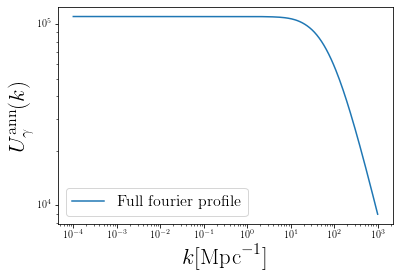

In [20]:
plt.plot(k_arr, DMAnnProfile(cM)._fourier(cosmo, k_arr, 1e12, 0.6, hmd_200c), '-', 
         label = r'${\rm Full}\,\,{\rm fourier}\,\,{\rm profile}$')
plt.ylabel(r'$U_{\gamma}^{\rm ann}(k)$', fontsize = 23)
plt.xlabel(r'$k [{\rm Mpc}^{-1}]$', fontsize = 23)
plt.legend(loc = 'lower left', fontsize = 16)
plt.loglog()

# 3. Measure F!
For this, we do:
$$
{\bf F}={\sf C}_F\,{\bf A}
$$
With
$$
({\sf C}_F^{-1})_{mn}=\sum_{gi\ell}\sum_{g'i'\ell'}C_\ell^{g,in}({\rm Cov}^{-1})_{(gi\ell),(g'i'\ell')}C_{\ell'}^{g',i'm}
$$
and
$$
A_n=\sum_{gi\ell}\sum_{g'i'\ell'}C_\ell^{g,in}({\rm Cov}^{-1})_{(gi\ell),(g'i'\ell')}\hat{C}_{\ell'}^{g'i'}
$$
Note that ${\sf C}_F$ also happens to be the covariance of ${\bf F}$.

Here $\hat{C}_\ell^{gi}$ is the data $g-i$ cross-correlation, and $C^{g,in}_\ell$ is the theoretical template for galaxy sample $g$ and window function $W_{n,i}(z)$.

At the end we multiply the result by $2.24686752\times10^8$ to convert $F$ from ${\rm cm}^{-2}{\rm s}^{-1}{\rm Mpc}^5 M_\odot^{-2}\,{\rm GeV}^{-1}$ to ${\rm s}^{-1}\,{\rm cm}^3\,{\rm GeV}^{-3}$.

In [25]:
def get_F(gals,cl_th):
    prefac = 2.24686752E8
    ngal = len(gals)
    gams = range(num_gam)

    # Get indices
    indices = []
    cl_data = []
    for igal, gal in enumerate(gals):
        indices.append([])
        cl_data.append([])
        for gam in gams:
            _, cl, ind = sa.get_ell_cl('cl_00', f'gal{gal}', f'gam{gam}', return_ind=True)
            indices[igal].append(ind)
            cl_data[igal].append(cl)
    indices = np.array(indices)
    cl_data = np.array(cl_data)

    # Get theory C_ells
    
    # Shape: [ngal, n_n, n_i, ell]
    cl_theory = np.array([cl_th[ig] for ig in gals])
    # Shape: [n_n, ngal, n_i, ell]
    cl_theory = np.transpose(cl_theory, axes=[1, 0, 2, 3])

    # Flatten all relevant dimensions
    cl_data = cl_data.flatten()
    indices = indices.flatten()
    cl_theory = cl_theory.reshape([num_E, -1])

    # Construct covariance
    cv = sa.covariance.covmat.copy()
    cv = cv[indices][:, indices]
    print(cv.shape)
    # Q matrix
    # Cov^-1 C_th
    iC_th = np.array([np.linalg.solve(cv, th)
                      for th in cl_theory])
    print(iC_th.shape)
    # C_th^T Cov^-1 C_th
    Q = np.sum(cl_theory[:, None, :]*iC_th[None, :, :], axis=-1)
    
    # A vector
    # C_th^T Cov^-1 d
    A = np.dot(cl_theory, np.linalg.solve(cv, cl_data))

    # F = Q^-1 F
    cov_F = np.linalg.inv(Q)
    F = np.dot(cov_F, A)
    
    # Chi^2 improvement
    chi20 = np.dot(cl_data, np.linalg.solve(cv, cl_data))
    res = cl_data - np.dot(F, cl_theory)
    chi2 = np.dot(res, np.linalg.solve(cv, res))

    # Prefactors
    F *= prefac
    cov_F *= prefac**2
    
    return F, cov_F

# 4. Saving

Now we can save our measurements of F. 

In [26]:
res_F_mid = {f'gal{i}': get_F([i],cl_th_mid) for i in range(6)}
res_F_mid['total'] = get_F(range(6),cl_th_mid)

(288, 288)
(12, 288)
(288, 288)
(12, 288)
(288, 288)
(12, 288)
(288, 288)
(12, 288)
(288, 288)
(12, 288)
(288, 288)
(12, 288)
(1728, 1728)
(12, 1728)


In [30]:
F_units = ['cm^-3 GeV^-3 s^-1']
Energy_units = ['GeV']
Fsave_mid = np.array([v[0] for k, v in res_F_mid.items()])
covFsave_mid = np.array([v[1] for k, v in res_F_mid.items()])
names = [k for k, v in res_F_mid.items()]
np.savez("F_annsubmid.npz", names=names, F=Fsave_mid, covF=covFsave_mid, Eeff = Eeff, z_mean = zmeans, 
        F_units = F_units, Energy_units = Energy_units)